In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tess_sip import SIP
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.print_figure_kwargs={"facecolor" : "w"}

In [29]:
t, f, f_err = np.genfromtxt(
    "/home/mango/Desktop/WASP50LC_ASASSN.txt",
    unpack=True,
    delimiter=',',
    skip_header=True,
)

<ErrorbarContainer object of 3 artists>

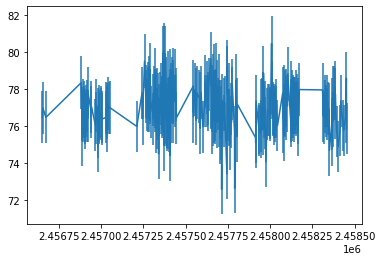

In [30]:
plt.errorbar(t, f, f_err)

In [26]:
np.isnan(f).sum()

0

/home/mango/miniconda3/envs/WASP50/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


<Quantity 5.21167883 d>

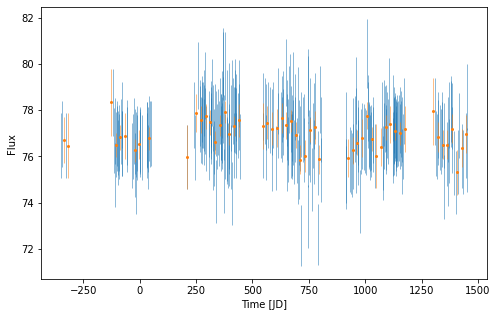

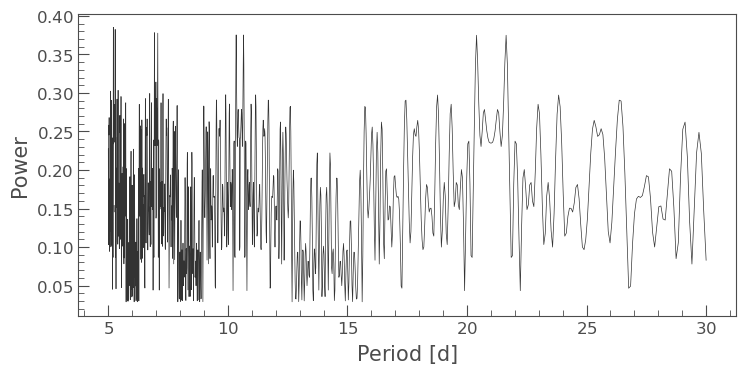

In [104]:
lc = lk.LightCurve(time=t - 2.457e6, flux=f, flux_err=f_err)
lc_binned = lc.bin(time_bin_size=21)

fig, ax = plt.subplots(figsize=(8, 5))
lc.errorbar(ax=ax)
lc_binned.errorbar(ax=ax, fmt='o')

pg = lc_binned.to_periodogram(minimum_period=5, maximum_period=30)
pg.plot()
pg.period_at_max_power

In [124]:
probabilities = [0.1, 0.05, 0.01]
pg._LS_object.false_alarm_level(probabilities)

array([ 8.18163696,  8.94600618, 10.66355903])

In [ ]:
tpfs = lk.search_targetpixelfile("WASP50", author="TESS-SPOC").download_all()

In [ ]:
[tpf.plot(aperture_mask="pipeline") for tpf in tpfs]

In [7]:
srs = lk.search_lightcurve("WASP50", author="TESS-SPOC")
display(srs)
lcs = srs.download_all()
#r = SIP(lcs, **sip_kwargs)

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 04,2018,TESS-SPOC,1800,382391899,0.0
1,TESS Sector 31,2020,TESS-SPOC,600,382391899,0.0


In [16]:
r = SIP(lcs)

/home/mango/miniconda3/envs/WASP50/lib/python3.9/site-packages/lightkurve/lightcurve.py:1031: LightkurveWarning: The light curve appears to be zero-centered (median=1.40e+03 electron / s +/- 7.57e+03 electron / s); `normalize()` will divide the light curve by a value close to zero, which is probably not what you want.
  warnings.warn(


Lightcurve File Input


Running pixels in aperture: 100%|██████████| 300/300 [00:01<00:00, 160.92it/s]


In [18]:
r.keys()

dict_keys(['periods', 'power', 'raw_lc', 'power_bkg', 'raw_lc_bkg', 'corr_lc', 'period_at_max_power', 'model'])

/home/mango/miniconda3/envs/WASP50/lib/python3.9/site-packages/lightkurve/lightcurve.py:1051: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a second time, which is probably not what you want.
  warnings.warn(


(1400.0, 1450.0)

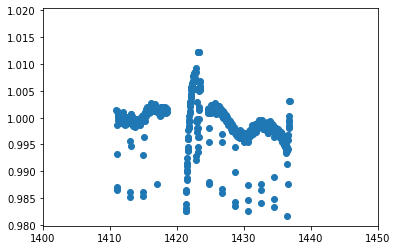

In [23]:
lc_corr = r["corr_lc"].remove_nans().remove_outliers().normalize()

plt.scatter(lc_corr.time.value, lc_corr.flux)
plt.xlim(1400, 1450)

In [3]:
t, f, f_err = np.genfromtxt(
    "/home/mango/Desktop/WASP50LC_ASASSN_binned.txt",
    unpack=True,
    delimiter=',',
    skip_header=1,
)

In [24]:
data = {
    "time":t,
    "flux":f,
    "flux_err":f_err,
}
lc_ASASSN = lk.LightCurve(data=data)
lc_ASASSN

time,flux,flux_err
,,
object,float64,float64
6654.8107259650715,-0.0008682310469305676,0.01414213562373095
6674.800516657066,0.002631768953069269,0.02
6887.064640546373,-0.0010348977135977342,0.011547005383792516
6895.05657414797,-0.0030348977135972177,0.011547005383792516
6902.688494404622,0.00196510228640238,0.011547005383792516
6909.476019632304,0.000631768953068601,0.01414213562373095
6921.023825019482,-0.00461823104693071,0.01
6943.5004607709125,-0.0033682310469309584,0.01414213562373095


<AxesSubplot:xlabel='Period [$\\mathrm{d}$]', ylabel='Power'>

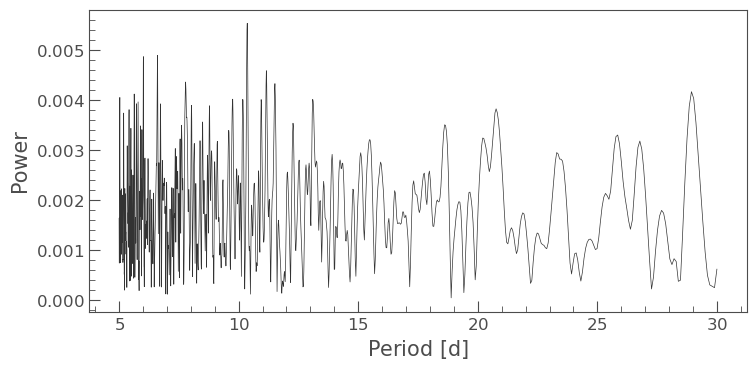

In [33]:
pg_ASASSN = lc_ASASSN.to_periodogram(minimum_period=5.0, maximum_period=30.0)
pg_ASASSN.plot()

In [ ]:
lc = lcs[0].remove_nans().normalize().remove_outliers()

In [ ]:
pg = lc.to_periodogram(minimum_period = 1.5,
                      maximum_period = 2.5,
                      oversample_factor=100)
pg.plot(view='period');

In [ ]:
new_period = pg.period_at_max_power
new_period

In [ ]:
plt.scatter(lc.time.value, lc.flux.value)

In [ ]:
lc_ASASN = lk.LightCurve()